# Digit with fastai

## Reading libaries

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
import sys
sys.path.append("../../dl1")

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import pandas as pd

#### The commands below is just to make sure cuda is ok and the acceleration is ok

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

## Data cleaning and preparation

In [6]:
data_PATH = "data/"
tmp_PATH = "tmp/"

In [7]:
data = pd.read_csv(f'{data_PATH}train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_x = pd.read_csv(f'{data_PATH}test.csv')
test_x.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Below is just to split data in train and val

In [9]:
train_data = data.sample(frac=0.8,random_state=200)
val_data = data.drop(train_data.index,axis=0)
train_y = train_data['label']
train_x = train_data.drop(train_y.name,axis=1)
val_y = val_data['label']
val_x = val_data.drop(val_y.name,axis=1)

print(np.shape(train_x))
print(np.shape(train_y))
print(np.shape(val_x))
print(np.shape(val_y))
print(np.shape(test_x))

(33600, 784)
(33600,)
(8400, 784)
(8400,)
(28000, 784)


In [10]:
train_x = train_x.as_matrix()
train_x = train_x.reshape(-1,28,28)
train_x = np.stack((train_x,)*3,axis=-1).astype('float32')
np.shape(train_x)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(33600, 28, 28, 3)

In [11]:
val_x = val_x.as_matrix()
val_x = val_x.reshape(-1,28,28)
val_x = np.stack((val_x,)*3,axis=-1).astype('float32')
np.shape(val_x)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(8400, 28, 28, 3)

In [12]:
test_x = test_x.as_matrix()
test_x = test_x.reshape(-1,28,28)
test_x = np.stack((test_x,)*3,axis=-1).astype('float32')
np.shape(test_x)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(28000, 28, 28, 3)

#### Check shapes and shows images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1 2 3 4 5 6 7 8 9]
(33600, 28, 28, 3)
(33600,)
(8400, 28, 28, 3)
(8400,)
(28000, 28, 28, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3


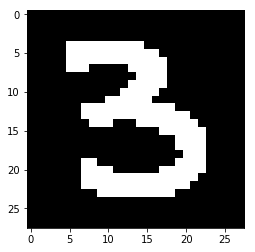

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


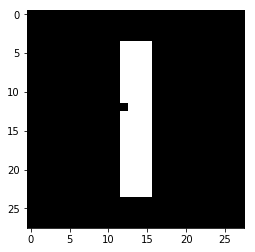

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


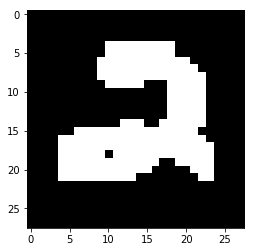

In [13]:
classes=np.unique(train_y)
train_y = np.array(train_y)
val_y = np.array(val_y)

print(classes)

print(np.shape(train_x))
print(np.shape(train_y))
print(np.shape(val_x))
print(np.shape(val_y))
print(np.shape(test_x))

print(type(train_x))
print(type(train_y))
print(type(val_x))

plt.imshow(train_x[0]);
print(train_y[0])
plt.show()
plt.close()

plt.imshow(val_x[0]);
print(val_y[0])
plt.show()
plt.close()

plt.imshow(test_x[0]);
plt.show()
plt.close()

## Fastai

In [14]:
sz=299
bs=64
arch=resnet34

In [15]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, max_zoom=1.1)
    data = ImageClassifierData.from_arrays(tmp_PATH, trn=(train_x, train_y), val=(val_x, val_y),
                                           classes=classes, tfms=tfms, bs=bs, num_workers=8)
    return data

In [16]:
data = get_data(sz, bs)
learn=ConvLearner.pretrained(arch, data, precompute=False)

In [17]:
lrf=learn.lr_find()

 82%|████████▏ | 429/525 [00:08<00:04, 21.77it/s, loss=2.17] 


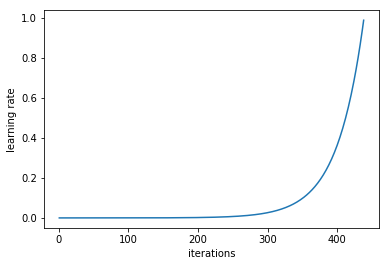

In [18]:
learn.sched.plot_lr()

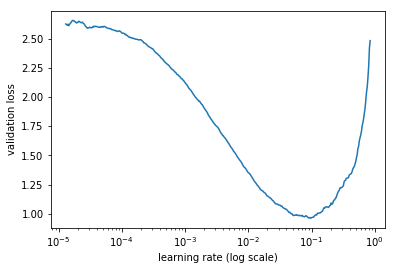

In [19]:
learn.sched.plot()

In [20]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.561563   0.462864   0.884286  
    1      0.507424   0.420768   0.895833                    



[array([0.42077]), 0.8958333333333334]

In [21]:
learn=ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.277718   0.167402   0.95119   
    1      0.229764   0.125879   0.960595                    



[array([0.12588]), 0.9605952380952381]

In [22]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.067769   0.040382   0.988333  
    1      0.037135   0.024358   0.992381                     
    2      0.02582    0.022409   0.993095                     
    3      0.026266   0.019302   0.994524                     
    4      0.022806   0.018005   0.995119                     
    5      0.015547   0.016837   0.995                        
    6      0.013319   0.016556   0.995238                      



[array([0.01656]), 0.9952380952380953]

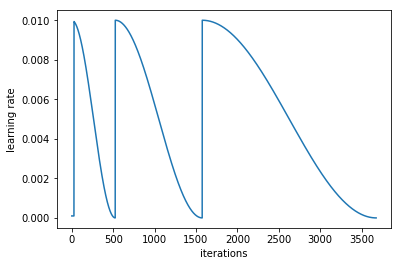

In [24]:
learn.sched.plot_lr()

In [23]:
#learn.save('standard_resnet34')

## Loading and predicting

In [17]:
learn.load('standard_resnet34')

In [18]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.9955952380952381

[[839   0   0   0   0   0   2   1   0   0]
 [  0 964   0   0   0   0   0   2   1   0]
 [  0   2 851   1   0   0   0   1   1   1]
 [  0   0   1 836   0   1   0   1   0   0]
 [  0   1   0   0 789   0   0   0   0   5]
 [  0   0   0   2   0 773   0   0   1   0]
 [  1   1   0   0   1   0 800   0   0   0]
 [  0   1   3   0   0   0   0 865   0   1]
 [  0   0   0   0   0   0   0   0 787   1]
 [  0   0   0   0   2   1   0   0   1 859]]


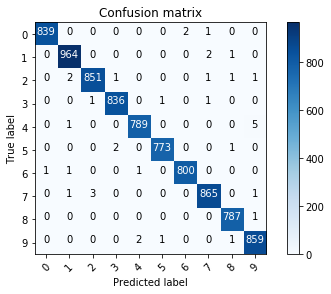

In [19]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

plot_confusion_matrix(cm, data.classes)

In [43]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, max_zoom=1.1)
    data = ImageClassifierData.from_arrays(tmp_PATH, trn=(train_x, train_y), val=(val_x, val_y),
                                           test=test_x, classes=classes, tfms=tfms, bs=bs, num_workers=8)
    return data

In [44]:
learn.set_data(get_data(sz,bs))
data = get_data(sz,bs)
log_preds_test,y_test = learn.TTA(is_test=True)
probs_test = np.mean(np.exp(log_preds_test),0)
preds_test = np.argmax(probs_test, axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


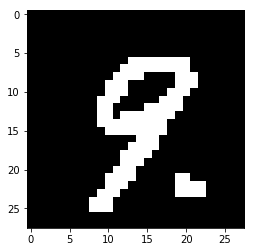

In [52]:
print(preds_test[0])
plt.imshow(test_x[0])

## Creating Kaggle submission file

In [57]:
np.shape(preds_test)

(28000,)

In [71]:
preds_test_pd = pd.DataFrame(preds_test, columns=["Label"])

ImageId = []
for i in range(0,np.shape(preds_test_pd)[0]):
    ImageId.append(i+1)

ImageId_pd = pd.DataFrame(ImageId, columns=["ImageId"])

In [72]:
ImageId_pd.head()

,ImageId
0,1
1,2
2,3
3,4
4,5


In [73]:
preds_test_pd.head()

,Label
0,2
1,0
2,9
3,0
4,3


In [74]:
shell = [ImageId_pd,preds_test_pd]
result = pd.concat(shell, axis=1, sort=False)
result.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [75]:
result.to_csv("prediction.csv", sep=',', index=False)